In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/terrestrial-data/TER20.csv
/kaggle/input/stin-dataset/SAT20.csv
/kaggle/input/satellite-dataset/SAT20.csv


   fl_dur  fw_pk  l_fw_pkt  l_bw_pkt  pkt_len_min  pkt_len_max  pkt_len_std  \
0       1      2         0         0            0            0          0.0   
1       1      2         0         0            0            0          0.0   
2       0      2         0         0            0            0          0.0   
3       1      2         0         0            0            0          0.0   
4       1      2         0         0            0            0          0.0   

   fl_byt_s  fl_iat_min  bw_iat_tot  ...  down_up_ratio  fw_byt_blk_avg  \
0       0.0           1           0  ...              0               0   
1       0.0           1           0  ...              0               0   
2       0.0           0           0  ...              0               0   
3       0.0           1           0  ...              0               0   
4       0.0           1           0  ...              0               0   

   fw_pkt_blk_avg  fw_blk_rate_avg  bw_byt_blk_avg  bw_pkt_blk_avg  \
0   

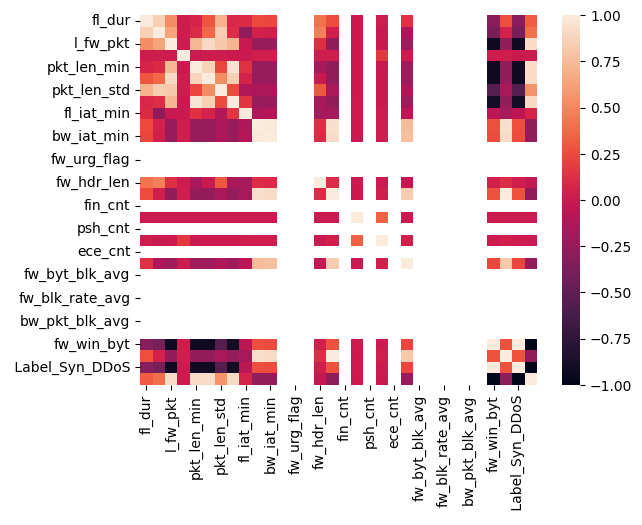

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv("../input/satellite-dataset/SAT20.csv")
df=df.dropna()
df = df.drop('id', axis=1)
print(df.head())
dfs = pd.get_dummies(df, columns=[' Label'])
correlation_matrix = dfs.corr(method='spearman')
#correlation_matrix.style.background_gradient(cmap='coolwarm')
#print(correlation_matrix)
sns.heatmap(correlation_matrix)
plt.show()
#plt.savefig('cor.png', bbox_inches='tight')



In [8]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
 

df = df.sample(n=100)
X= df.drop(' Label', axis=1)
y = df[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

sfs = SFS(RandomForestClassifier(max_depth=2, random_state=0),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 0)
sfs.fit(X,y)
print(sfs.k_feature_names_)

('fl_dur', 'fw_pk', 'l_fw_pkt', 'l_bw_pkt', 'pkt_len_min', 'pkt_len_max', 'pkt_len_std', 'fl_byt_s', 'fl_iat_min', 'bw_iat_tot')


In [10]:
#integrating data cleaning, feature extraction, data preprocessing

import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Data preparation
df_sat = pd.read_csv("../input/satellite-dataset/SAT20.csv")
df_ter = pd.read_csv("../input/terrestrial-data/TER20.csv")

frames = [df_sat, df_ter]
df_concat = pd.concat(frames)
df_concat.drop(columns='id', inplace=True)

print(df_concat.head())
print(df_concat.shape)

# sample the dataset for easier debugging
# df_concat = df_concat.sample(n=100)

# These columns give problems with NaNs after normalizing
df_concat = df_concat.drop(columns=['syn_cnt', 'urg_cnt', 'bw_psh_flag', 'fw_urg_flag', 'bw_urg_flag', 'fin_cnt', 'psh_cnt', 'ece_cnt', 'fw_byt_blk_avg', 'fw_pkt_blk_avg', 'fw_blk_rate_avg', 'bw_byt_blk_avg', 'bw_pkt_blk_avg', 'bw_blk_rate_avg'])
print(df_concat.head())

# Minority removal (merge data)
labels = {
    'Syn_DDoS': 'Syn_DDoS',
    'UDP_DDoS': 'UDP_DDoS',
    'Botnet': 'Botnet',
    'Portmap_DDoS': 'DDoS',
    'Backdoor': 'Botnet',
    'Web Attack': 'Botnet',
    'LDAP_DDoS': 'DDoS',
    'MSSQL_DDoS': 'DDoS',
    'NetBIOS_DDoS': 'DDoS'
}
df_concat[' Label'] = df_concat[' Label'].map(labels)
print(df_concat[' Label'].value_counts())

# Extract the label column
y = df_concat[' Label']
df_concat.drop(columns=' Label', inplace=True)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# min max normalize
normalized_df=(df_concat-df_concat.min())/(df_concat.max()-df_concat.min())
print(normalized_df.head())

X = normalized_df

sfs = SFS(RandomForestClassifier(max_depth=2, random_state=0),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 0)
sfs.fit(X,y_encoded)
print(sfs.k_feature_names_)

X = X[np.array(sfs.k_feature_names_)]

   fl_dur  fw_pk  l_fw_pkt  l_bw_pkt  pkt_len_min  pkt_len_max  pkt_len_std  \
0       1      2         0         0            0            0          0.0   
1       1      2         0         0            0            0          0.0   
2       0      2         0         0            0            0          0.0   
3       1      2         0         0            0            0          0.0   
4       1      2         0         0            0            0          0.0   

   fl_byt_s  fl_iat_min  bw_iat_tot  ...  down_up_ratio  fw_byt_blk_avg  \
0       0.0           1           0  ...              0               0   
1       0.0           1           0  ...              0               0   
2       0.0           0           0  ...              0               0   
3       0.0           1           0  ...              0               0   
4       0.0           1           0  ...              0               0   

   fw_pkt_blk_avg  fw_blk_rate_avg  bw_byt_blk_avg  bw_pkt_blk_avg  \
0   

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder



# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_encoded_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# GRU Model
model = Sequential()

model = Sequential()
model.add(GRU(50, input_shape=(10, 1), return_sequences=True))  # GRU input layer with 10 time steps and 1 feature
model.add(GRU(50, return_sequences=True))  # First hidden GRU layer
model.add(GRU(50, return_sequences=True))  # Second hidden GRU layer
model.add(GRU(50))  # Third hidden GRU layer
model.add(Dense(y_encoded_onehot.shape[1], activation='softmax'))  # Output layer


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded_onehot, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
5240/5240 [==============================] - 53s 8ms/step - loss: 0.4564 - accuracy: 0.7944
Epoch 2/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3960 - accuracy: 0.8223
Epoch 3/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3849 - accuracy: 0.8265
Epoch 4/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3784 - accuracy: 0.8292
Epoch 5/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3672 - accuracy: 0.8354
Epoch 6/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3603 - accuracy: 0.8443
Epoch 7/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3572 - accuracy: 0.8458
Epoch 8/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3586 - accuracy: 0.8442
Epoch 9/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3540 - accuracy: 0.8458
Epoch 10/10
1310/1310 [==============================] - 6s 4ms/step - lo

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 10, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 10, 50)            15300     
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 54,054
Trainable params: 54,054
Non-trainable params: 0
_________________________________________________________________


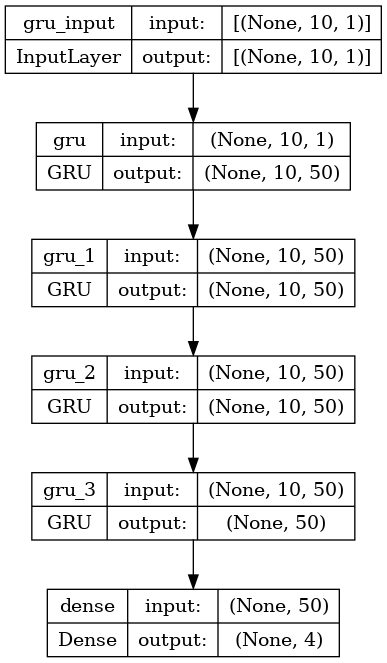

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
model.summary()

#Model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Image('model.png')